In [1]:
from glob import glob
from astropy.io import fits

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage


# statistics
from astropy.stats import biweight_location, biweight_scale, sigma_clipped_stats
from scipy.stats import median_abs_deviation

# configuration
np.set_printoptions(linewidth=120) # para que se vea
plt.rcParams["image.cmap"] = "gray" # https://matplotlib.org/stable/users/explain/colors/colormaps.html
plt.rcParams["image.origin"] = "lower"

def quantile_imshow(img,lower=0.01,upper=0.99,**kwargs):
    img_vmin = np.quantile(img,lower)
    img_vmax = np.quantile(img,upper)
    return plt.imshow(img,vmin=img_vmin,vmax=img_vmax,**kwargs)

In [2]:
from astropy.io import fits
from glob import glob
files = glob("*.fits")
files

['Alcyone.fits', 'sextansA_mask.fits', 'sextans_A.fits']

In [3]:
Alcyone= fits.getdata(files[0])
sextans_A=fits.getdata(files[2])
Filtro=fits.getdata(files[1])

In [4]:
fits.getheader(files[0])

SIMPLE  =                    T /                                                
BITPIX  =                   16 /                                                
NAXIS   =                    2 /                                                
NAXIS1  =                  765 /                                                
NAXIS2  =                  510 /                                                
EXTEND  =                    T                                                  
OBJECT  = 'Alcyone '                                                            
TELESCOP= 'Meade LX200'                                                         
INSTRUME= 'SBIG ST-402'                                                         
OBSERVER= 'Maria Gracia Batista'                                                
DATE-OBS= '2024-02-10T01:39:58.000' / GMT START OF EXPOSURE [WIN]               
BSCALE  =                    1                                                  
BZERO   =                327

In [5]:
fits.getheader(files[1])

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1701                                                  
NAXIS2  =                 1501                                                  
EXTEND  =                    T                                                  

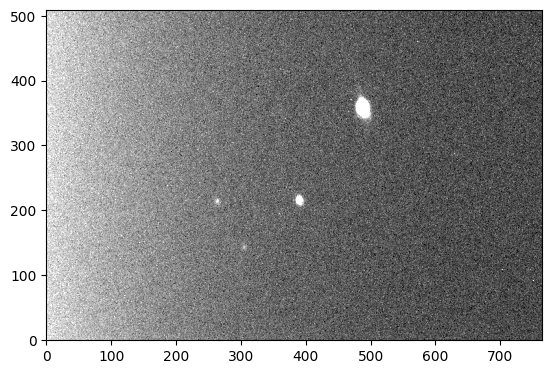

In [6]:
quantile_imshow(Alcyone)

Text(0.5, 1.0, 'Imagen Sextans')

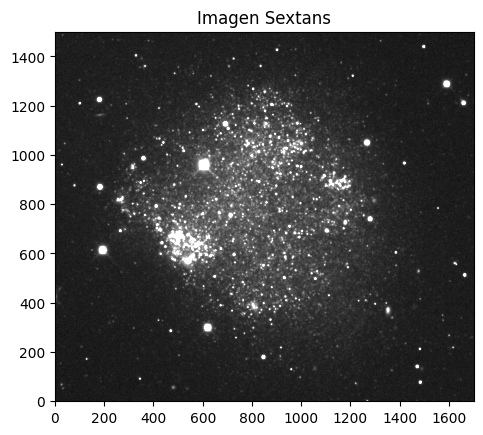

In [7]:
quantile_imshow(sextans_A)
plt.title("Imagen Sextans")

In [8]:
fits.info(files[1])

Filename: sextansA_mask.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (1701, 1501)   int64   


In [9]:
head = {}
data = {}
with fits.open("sextans_A.fits") as image_list:
    for image in image_list:
        head[image.name] = image.header
        data[image.name] = image.data.astype(float)

In [10]:
head

{'B': SIMPLE  =                    T / Fits standard                                  
 BITPIX  =                  -32 / Bits per pixel                                 
 NAXIS   =                    2 / Number of axes                                 
 NAXIS1  =                 1701 / Axis length                                    
 NAXIS2  =                 1501 / Axis length                                    
 EXTEND  =                    T / File may contain extensions                    
 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
 DATE    = '2015-07-24T20:23:18' / Date FITS file was generated                  
 IRAF-TLM= '2015-07-24T20:23:18' / Time of last modification                     
 OBJECT  = 'SextansA B'         / Name of the object observed                    
 FILENAME= 'obj151  '           / Original host filename                         
 OBSTYPE = 'object  '           / Observation type                               
 PREFLASH= 

In [11]:
head["R"]["EXPTIME"]

50.0

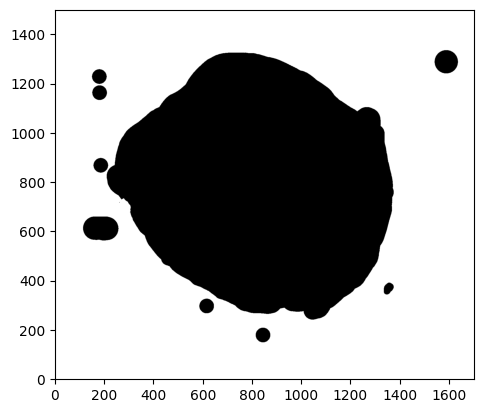

In [13]:
quantile_imshow(Filtro)

In [386]:
dataU=data["U"]
dataR=data["R"]

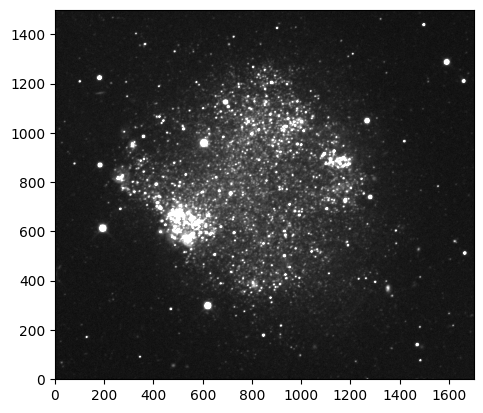

In [390]:
quantile_imshow(dataU)

In [391]:
from skimage.feature import peak_local_max
import scipy.ndimage as ndi
from photutils.centroids import centroid_sources, centroid_quadratic # can be any of centroid_1dg, centroid_2dg, centroid_com, centroid_quadratic

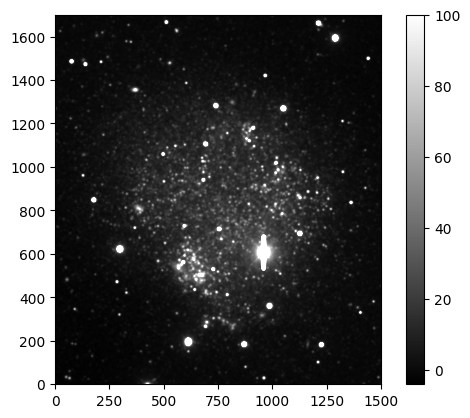

In [392]:
plt.imshow(ndi.gaussian_filter(dataR,3).T,vmax=100)
plt.colorbar()

In [454]:
peaksR = peak_local_max(
    ndi.gaussian_filter(dataR,1.5),
    threshold_abs=35,
    labels=Filtro.astype(int)*1,
    min_distance=10,
    exclude_border=15
)
peaksU = peak_local_max(
    ndi.gaussian_filter(dataU,1.5),
    threshold_abs=13,
    labels=Filtro.astype(int)*1,
    min_distance=9,
    exclude_border=12
)
len(peaksR),len(peaksU)

(123, 90)

Text(0.5, 1.0, 'Estrellas encontradas en el filtro R')

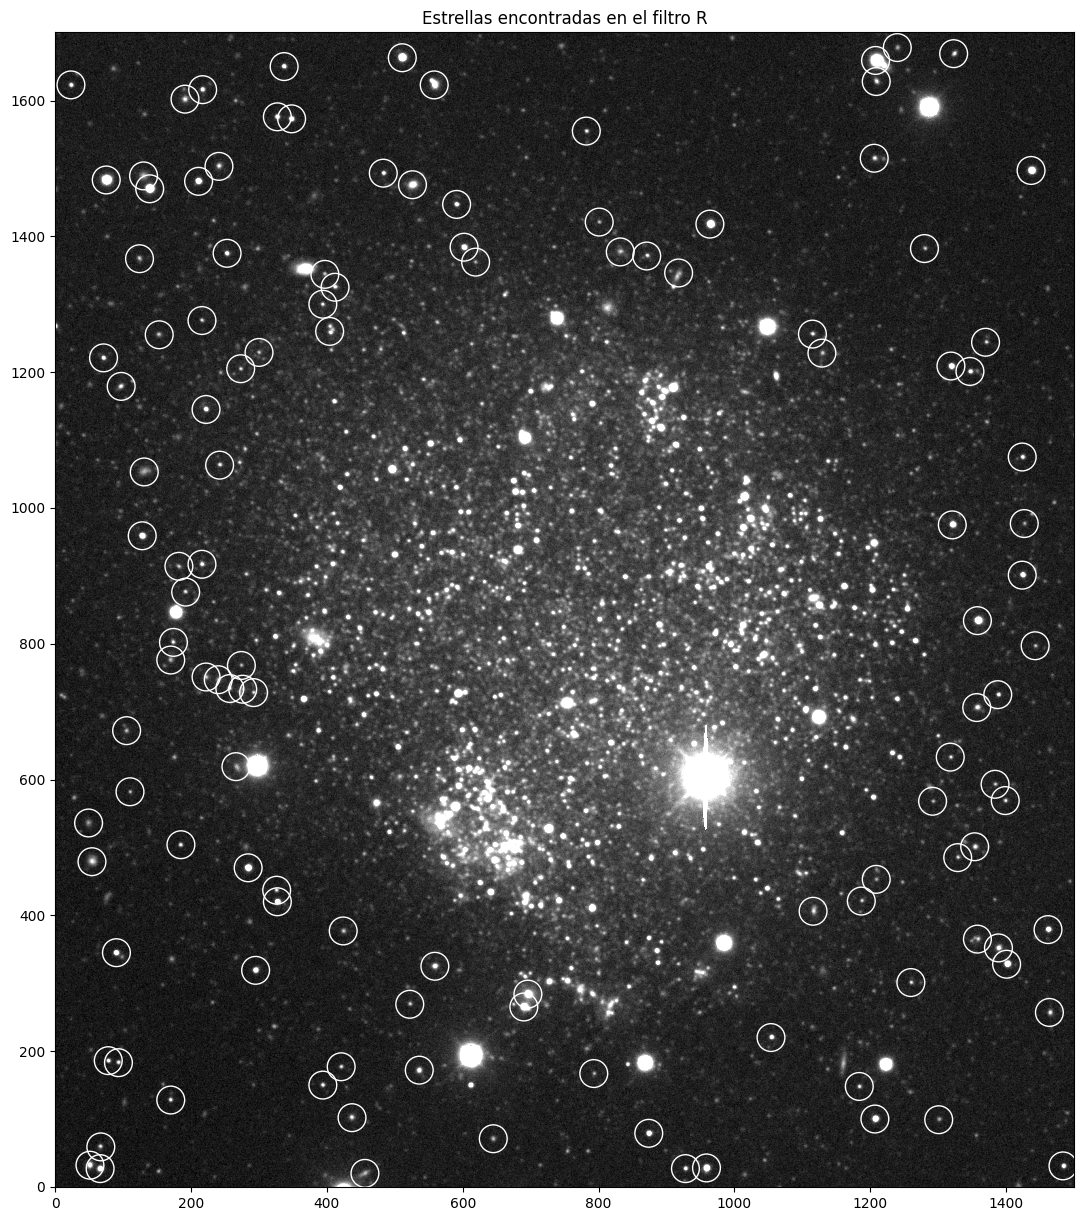

In [455]:
plt.figure(figsize=(15,15))
quantile_imshow(dataR.T)
plt.scatter(*peaksR.T,fc="none",ec="w",s=400)
plt.title("Estrellas encontradas en el filtro R")

Text(0.5, 1.0, 'Estrellas encontradas en el filtro U')

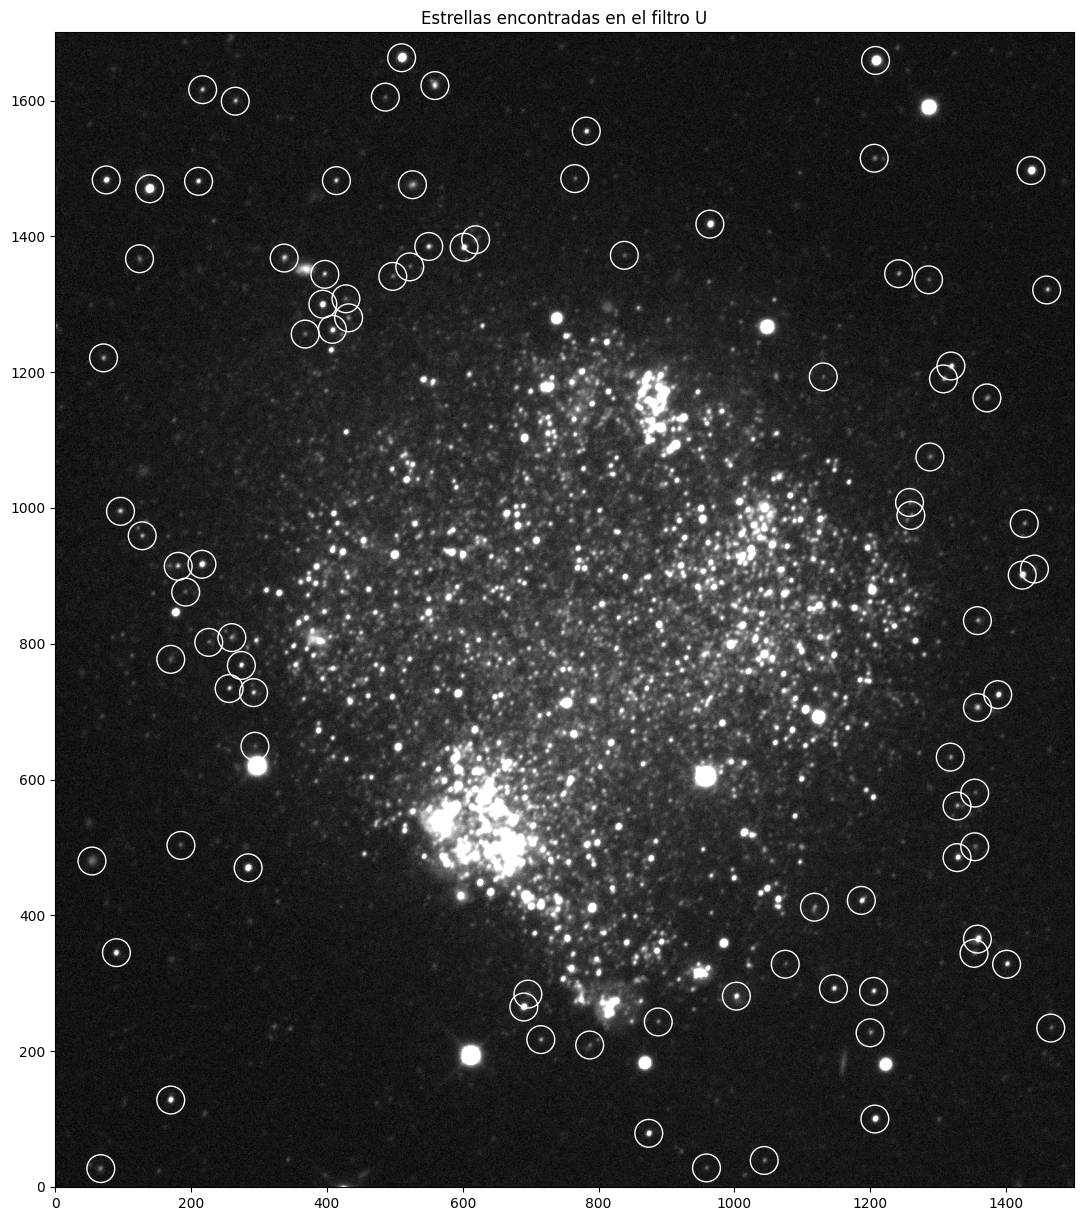

In [456]:
plt.figure(figsize=(15,15))
quantile_imshow(dataU.T)
plt.scatter(*peaksU.T,fc="none",ec="w",s=400)
plt.title("Estrellas encontradas en el filtro U")

In [457]:
centroidsR = np.array(
    centroid_sources((dataR-dataR.mean()).T,*peaksR.T,centroid_func=centroid_quadratic,box_size=9)
).T

centroidsU = np.array(
    centroid_sources((dataU-dataU.mean()).T,*peaksU.T,centroid_func=centroid_quadratic,box_size=9)
).T


In [458]:
distancesU = np.hypot(*(peaksU-centroidsU).T)
distancesR = np.hypot(*(peaksR-centroidsR).T)


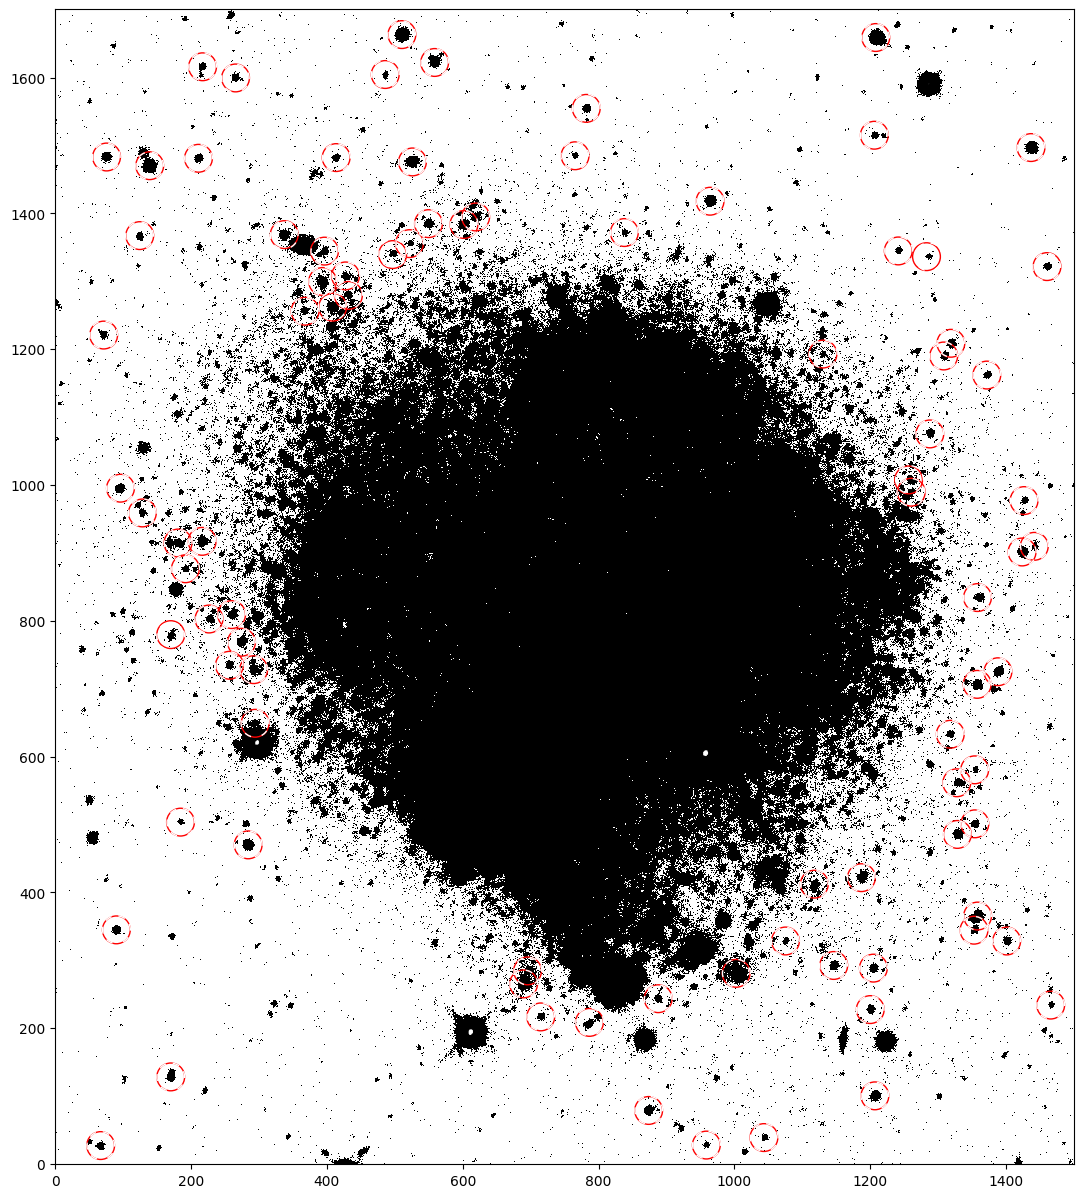

In [459]:
plt.figure(figsize=(15,15))
plt.imshow(dataU.T,vmin=10000,norm="log")
plt.scatter(*centroidsU.T,fc="none",ec="r",s=400)
plt.scatter(*peaksU.T,fc="none",ec="w",s=400,linestyle=(5,(5,5)))

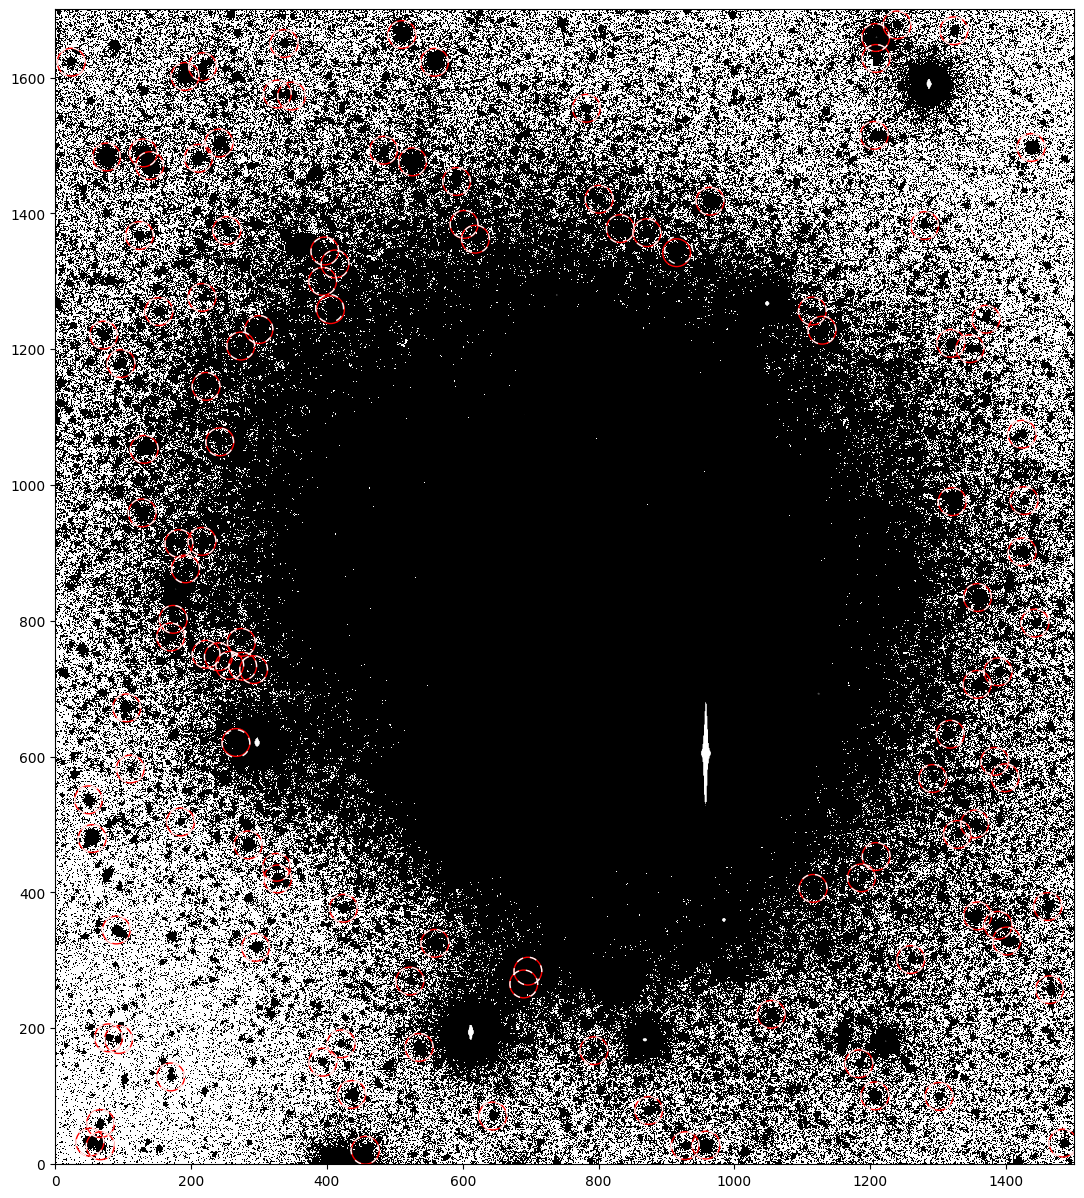

In [460]:
plt.figure(figsize=(15,15))
plt.imshow(dataR.T,vmin=10000,norm="log")
plt.scatter(*centroidsR.T,fc="none",ec="r",s=400)
plt.scatter(*peaksR.T,fc="none",ec="w",s=400,linestyle=(5,(5,5)))

In [461]:
from photutils.aperture import CircularAperture, ApertureStats
from photutils.profiles import RadialProfile
from astropy.modeling.models import Gaussian1D,Voigt1D,Const1D
from astropy.modeling.fitting import LevMarLSQFitter
fitter = LevMarLSQFitter(calc_uncertainties=True)

In [462]:
model = Const1D(100) + Gaussian1D(5e3,0,1.5)
model.mean_1.fixed = True

In [463]:
radii = np.arange(0,10,1)
profileR = RadialProfile(dataR.T,centroidsR[0],radii)
fitted_modelR = fitter(model,profileR.radius,profileR.profile)

profileU = RadialProfile(dataU.T,centroidsU[0],radii)
fitted_modelU = fitter(model,profileU.radius,profileU.profile)


In [464]:
paramsU = []
params_stdU = []
for c in centroidsU:
    try:
        profile = RadialProfile(dataU.T,c,radii)
        fitted_model = fitter(model,profile.radius,profile.profile)
        params_stdU.append(np.sqrt(np.diag(fitter.fit_info["param_cov"])))
        paramsU.append(fitted_model.parameters)
    except ValueError:
        pass
    #plt.plot(profile.radius,profile.gaussian_profile)
    #plt.plot(profile.radius,profile.profile,". k")
    #plt.show()
    #plt.close()

paramsU= np.asarray(paramsU)
params_stdU = np.asarray(params_stdU)

x = np.log10(paramsU.T[1])
y = 2*np.sqrt(2*np.log(2))*paramsU.T[3]
dx = params_stdU.T[1]/paramsU.T[1] / np.log(10)
dy = 2*np.sqrt(2*np.log(2))*params_stdU.T[2]
dx=np.abs(dx)
dy=np.abs(dy)

samples = np.random.normal(loc=y,scale=dy,size=(10_000,len(y)))
means = samples.mean(axis=1)

FWHMVU = means.mean()
FWHM_errU = means.std()
FWHMVU

5.547739838518232

Text(0.5, 1.0, 'FWHM mean = $5.548\\pm0.029$')

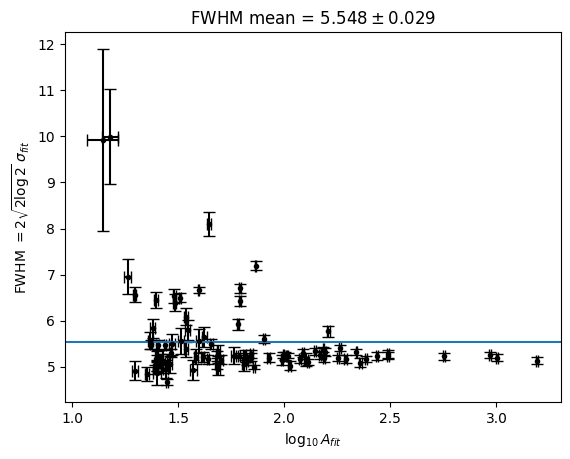

In [465]:
plt.errorbar(x,y,dy,dx,fmt=". k",capsize=4)

plt.xlabel("$\\log_{10} A_{fit}$")
plt.ylabel("FWHM $= 2\\sqrt{2\\log 2}\\;\\sigma_{fit}$")

plt.axhline(FWHMVU)
plt.title(f"FWHM mean = ${FWHMVU:.3f}\\pm{FWHM_errU:.3f}$")

In [466]:
paramsR = []
params_stdR = []
for c in centroidsR:
    try:
        profile = RadialProfile(dataR.T,c,radii)
        fitted_model = fitter(model,profile.radius,profile.profile)
        params_stdR.append(np.sqrt(np.diag(fitter.fit_info["param_cov"])))
        paramsR.append(fitted_model.parameters)
    except ValueError:
        pass
    #plt.plot(profile.radius,profile.gaussian_profile)
    #plt.plot(profile.radius,profile.profile,". k")
    #plt.show()
    #plt.close()

paramsR = np.asarray(paramsR)
params_stdR = np.asarray(params_stdR)

x = np.log10(paramsR.T[1])
y = 2*np.sqrt(2*np.log(2))*paramsR.T[3]
dx = params_stdR.T[1]/paramsR.T[1] / np.log(10)
dy = 2*np.sqrt(2*np.log(2))*params_stdR.T[2]
dx=np.abs(dx)
dy=np.abs(dy)

samples = np.random.normal(loc=y,scale=dy,size=(10_000,len(y)))
means = samples.mean(axis=1)

FWHMVR = means.mean()
FWHM_errR = means.std()
FWHMVR

4.872879312797574

Text(0.5, 1.0, 'FWHM mean = $4.873\\pm0.012$')

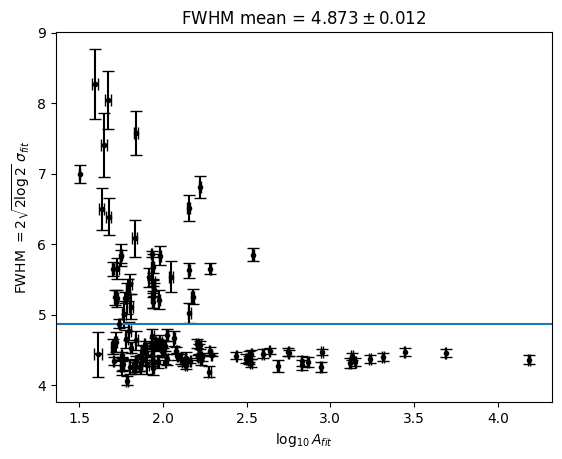

In [467]:
plt.errorbar(x,y,dy,dx,fmt=". k",capsize=4)

plt.xlabel("$\\log_{10} A_{fit}$")
plt.ylabel("FWHM $= 2\\sqrt{2\\log 2}\\;\\sigma_{fit}$")

plt.axhline(FWHMVR)
plt.title(f"FWHM mean = ${FWHMVR:.3f}\\pm{FWHM_errR:.3f}$")

In [468]:
centroidsU=centroidsU[~np.isnan(np.sum(centroidsU,axis=1))]
centroidsR=centroidsR[~np.isnan(np.sum(centroidsR,axis=1))]

In [469]:
from sklearn.neighbors import NearestNeighbors


In [470]:
distanciaminR,indx=NearestNeighbors(n_neighbors=2).fit(centroidsR).kneighbors(centroidsR)
distanciaminU,indx=NearestNeighbors(n_neighbors=2).fit(centroidsU).kneighbors(centroidsU)

In [471]:
from photutils.aperture import CircularAnnulus

In [472]:
np.shape(centroidsU)

(89, 2)

In [475]:
min(distanciaminR[:,1])-FWHMVR,min(distanciaminR[:,1]),FWHMVR*1.9

(10.197843053854015, 15.070722366651589, 9.25847069431539)

In [478]:
sky_aperturesU= CircularAnnulus(centroidsU,1.9*FWHMVU,(min(distanciaminU[:,1])-FWHMVU))
star_aperturesU= CircularAperture(centroidsU,FWHMVU)

sky_aperturesR= CircularAnnulus(centroidsR,1.9*FWHMVR,(min(distanciaminR[:,1])-FWHMVR))
star_aperturesR= CircularAperture(centroidsR,FWHMVR)


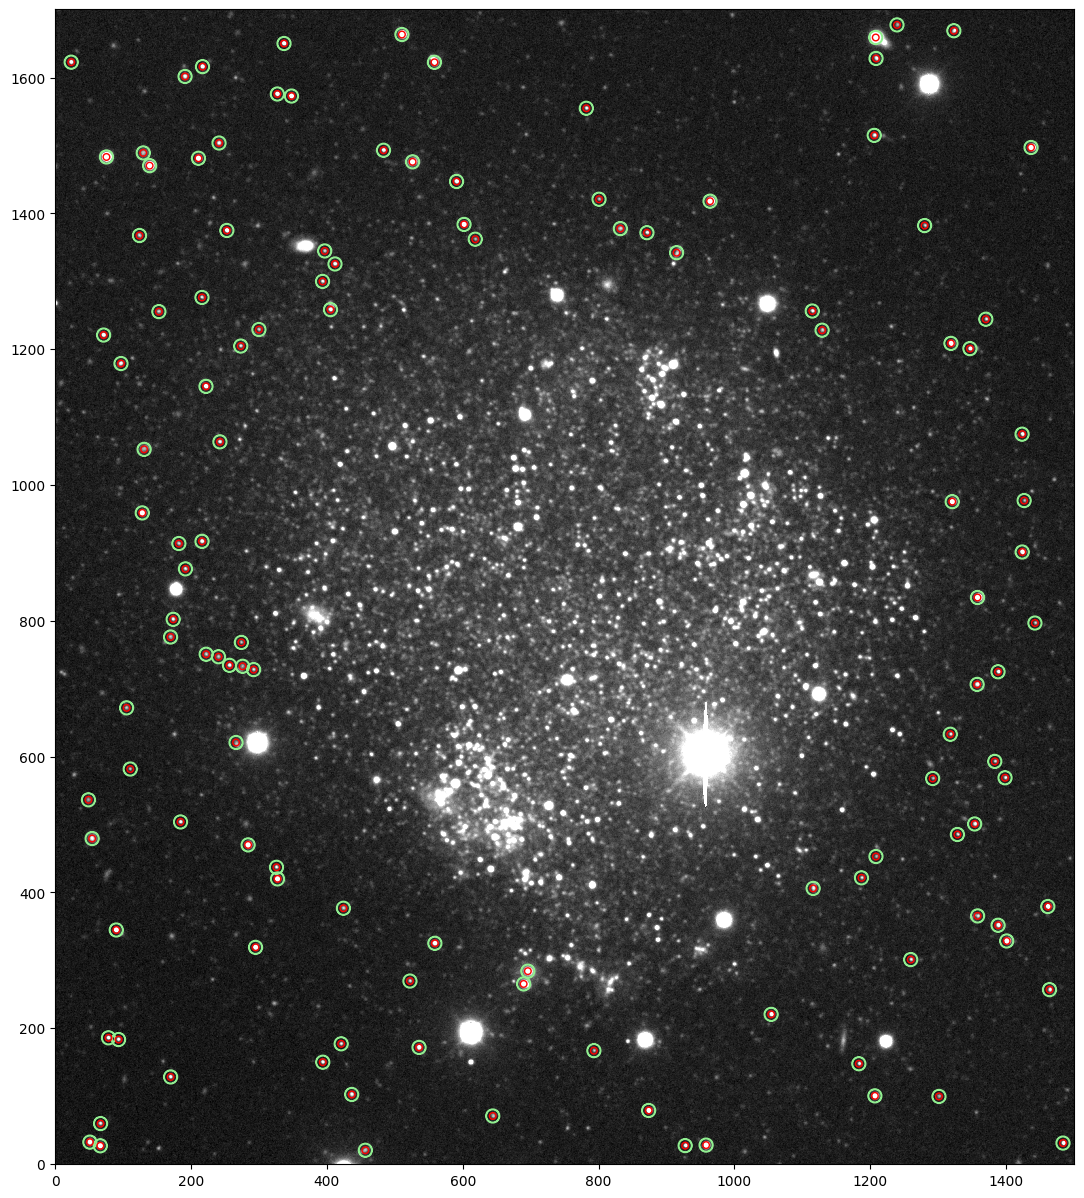

In [479]:
plt.figure(figsize=(15,15))
quantile_imshow(dataR.T);
sky_aperturesR.plot(color="lightgreen");
star_aperturesR.plot(color="red");

In [480]:
skyvaluesR=ApertureStats(dataR.T,sky_aperturesR).median
star_valuesR=ApertureStats(dataR.T,star_aperturesR).sum / star_aperturesR.area

skyvaluesU=ApertureStats(dataU.T,sky_aperturesU).median
star_valuesU=ApertureStats(dataU.T,star_aperturesU).sum / star_aperturesU.area


In [481]:
mag_ins_R=-2.5*np.log10((star_valuesR-skyvaluesR)/head["R"]["EXPTIME"])+19.5
mag_ins_U=-2.5*np.log10((star_valuesU-skyvaluesU)/head["U"]["EXPTIME"])+19.5


In [482]:
U=0.6
B=0.4
V=0.2
R=0.1
I=0.08

In [483]:
print(head["B"]["AIRMASS"])

1.324


In [484]:
mag_ins_U=mag_ins_U+head["U"]["AIRMASS"]*U
mag_ins_R=mag_ins_R+head["R"]["AIRMASS"]*R

In [485]:
len(centroidsI),len(centroidsR)

(108, 123)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,  14,  15,  16,  18,  19,  22,  23,  25,  26,
        27,  35,  40,  46,  47,  48,  56,  58,  60,  61,  67,  73,  74,  78,  80,  83,  88,  89,  91,  94, 103, 113,
       122], dtype=int64), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int64))


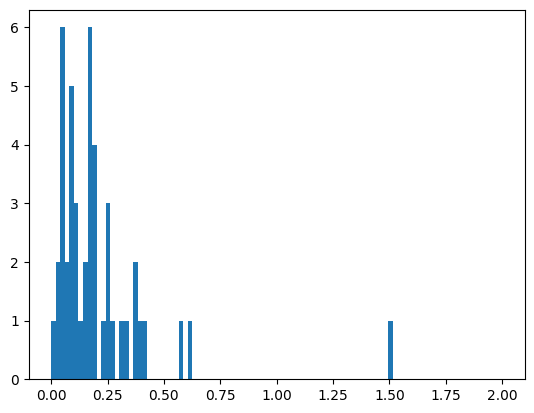

In [487]:
f=NearestNeighbors(n_neighbors=1,radius=1).fit(centroidsU).kneighbors(centroidsR)
dis=f[0]
ind=f[1]

plt.hist(dis,bins=np.linspace(0,2,100))
disme0=np.where(dis<1.25)
print(disme0)
inndme0=ind[disme0[0]]

In [493]:
mag_U=mag_ins_U[inndme0]
mag_R=mag_ins_R[disme0[0]]

In [494]:
mag_U=np.array(mag_U)
mag_R=np.array(mag_R)
np.shape(mag_I.ravel()),np.shape(mag_R.ravel())

((45,), (45,))

In [495]:
X=np.load("sextansA_PSF.npy",allow_pickle=True)[()]
X

{'B_xy': array([[1220.71893339,   71.33531454],
        [1482.96387635,   75.5384367 ],
        [ 344.65716677,   89.96434264],
        ...,
        [1496.7981587 , 1437.08272313],
        [1321.56575686, 1460.53221897],
        [ 379.05156784, 1461.73658713]]),
 'V_xy': array([[1622.44118114,   23.61349726],
        [  32.29915279,   50.90241422],
        [  26.89187253,   66.45457166],
        ...,
        [ 256.78581344, 1464.31794332],
        [1007.71869931, 1469.95152731],
        [  30.77964513, 1484.14063352]]),
 'B_mag': array([22.65061259, 19.79593898, 21.67996182, 23.24688572, 21.757967  , 19.44434815, 22.19556875, 18.4938923 ,
        23.40777707, 21.41635999, 22.02531258, 22.40367884, 23.27135446, 22.2148721 , 22.7992883 , 22.46726415,
        20.50581998, 22.44925944, 22.36814332, 22.18060744, 23.06351666, 23.44813905, 22.45245072, 21.36830653,
        23.19857498, 23.04756869, 22.21246284, 22.11595306, 22.32134371, 22.4652891 , 22.01174671, 22.0163397 ,
        22.829474

In [496]:
f=NearestNeighbors(n_neighbors=1).fit(X["V_xy"]).kneighbors(X["B_xy"])
dis=f[0]
inds=f[1]
inddis=np.where(dis)
k=inds[inddis[0]].ravel()
Bmag=X["B_mag"]
Vmag=X["V_mag"][k]

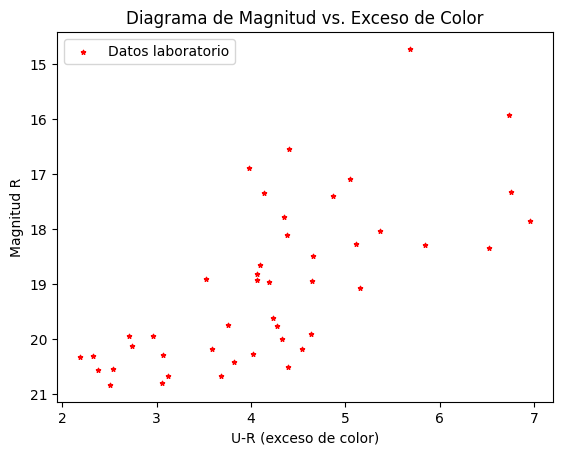

In [499]:
x=-mag_R.ravel()+mag_U.ravel()




plt.scatter(x, mag_R,  marker = "*",label='Datos laboratorio',s=10,c="r")

# Etiquetas y título
plt.xlabel('U-R (exceso de color)')
plt.ylabel('Magnitud R')
plt.title('Diagrama de Magnitud vs. Exceso de Color')

# Invertir eje y
plt.gca().invert_yaxis()

# Mostrar leyenda
plt.legend()

# Mostrar gráfico
plt.show()

In [362]:
min(distanciaminI[:,1])

16.266887299655686

{'B_xy': array([[1220.71893339,   71.33531454],
        [1482.96387635,   75.5384367 ],
        [ 344.65716677,   89.96434264],
        ...,
        [1496.7981587 , 1437.08272313],
        [1321.56575686, 1460.53221897],
        [ 379.05156784, 1461.73658713]]),
 'V_xy': array([[1622.44118114,   23.61349726],
        [  32.29915279,   50.90241422],
        [  26.89187253,   66.45457166],
        ...,
        [ 256.78581344, 1464.31794332],
        [1007.71869931, 1469.95152731],
        [  30.77964513, 1484.14063352]]),
 'B_mag': array([22.65061259, 19.79593898, 21.67996182, 23.24688572, 21.757967  , 19.44434815, 22.19556875, 18.4938923 ,
        23.40777707, 21.41635999, 22.02531258, 22.40367884, 23.27135446, 22.2148721 , 22.7992883 , 22.46726415,
        20.50581998, 22.44925944, 22.36814332, 22.18060744, 23.06351666, 23.44813905, 22.45245072, 21.36830653,
        23.19857498, 23.04756869, 22.21246284, 22.11595306, 22.32134371, 22.4652891 , 22.01174671, 22.0163397 ,
        22.829474

In [286]:
np.shape(X["B_xy"])

(674, 2)

In [287]:
np.shape(X["V_xy"])

(939, 2)

array([  3,   4,   6,  10,  10,  11,  12,  16,  18,  19,  21,  23,  24,  29,  30,  33,  35,  36,  38,  41,  42,  45,
        44,  46,  49,  50,  48,  52,  56,  57,  58,  60,  59,  61,  62,  64,  67,  68,  69,  70,  72,  73,  74,  75,
        77,  78,  79,  82,  98,  85,  86,  89,  92,  90,  87,  88,  93,  97,  98, 100, 103, 106, 105, 107, 110, 109,
       111, 112, 113, 114, 117, 118, 119, 120, 122, 125, 123, 124, 126, 127, 130, 131, 131, 135, 136, 144, 143, 145,
       146, 147, 149, 148, 150, 151, 153, 159, 154, 156, 162, 159, 161, 162, 163, 141, 166, 167, 156, 172, 167, 176,
       174, 175, 179, 180, 241, 166, 181, 184, 185, 186, 187, 188, 191, 194, 195, 196, 197, 198, 201, 202, 203, 204,
       205, 200, 222, 207, 208, 210, 212, 213, 215, 217, 219, 218, 221, 222, 223, 225, 226, 227, 228, 229, 230, 231,
       233, 211, 237, 242, 234, 238, 241, 242, 240, 229, 228, 244, 245, 247, 249, 252, 250, 254, 256, 258, 259, 257,
       245, 264, 266, 267, 269, 270, 272, 273, 275, 280, 281, 28

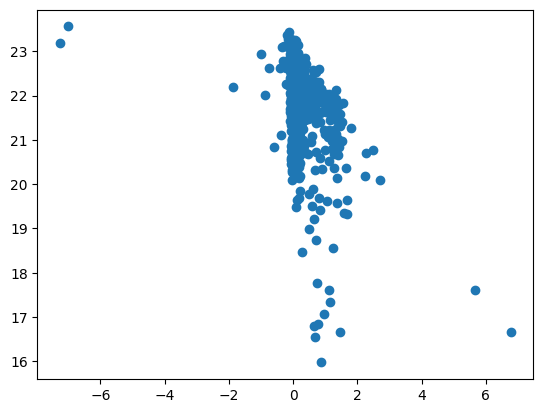